In [1]:
%matplotlib inline


Hovmoller Diagram Example
=========================

By: Kevin Goebbert

Northern Hemispheric v-wind component over the mid-latitudes in a
Hovmoller diagram. This diagram can be used to illustrate upper-level
wave and energy propogation (e.g., downstream baroclinic development)


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr

Get the data
------------

Using NCEP/NCAR reanalysis data via xarray remote access using the
OPeNDAP protocol.

Set the time range, parameter, and level to desired values




In [3]:
# Create time slice from dates
start_time = '2023-01-20'
end_time = '2023-02-06'

# Select NCEP/NCAR parameter and level
param = 'vwnd'
level = 250

# Remote get dataset using OPeNDAP method via xarray
ds = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/'
                     'ncep.reanalysis/pressure/{}.{}.nc'.format(param, start_time[:4]))

# Create slice variables subset domain
time_slice = slice(start_time, end_time)
#lat_slice = slice(60, 40)
lat_slice = slice(15, -20)

lon_slice = slice(0, 360)

# Get data, selecting time, level, lat/lon slice
data = ds[param].sel(time=time_slice,
                     level=level,
                     lat=lat_slice,
                     lon=lon_slice)

# Compute weights and take weighted average over latitude dimension
weights = np.cos(np.deg2rad(data.lat.values))
avg_data = (data * weights[None, :, None]).sum(dim='lat') / np.sum(weights)

# Get times and make array of datetime objects
vtimes = data.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = data.lon.values

Make the Hovmoller Plot
-----------------------

Pretty simple to use common matplotlib/cartopy to create the diagram.
Cartopy is used to create a geographic reference map to highlight the
area being averaged as well as the visual reference for longitude.




/home/casamentos/anaconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


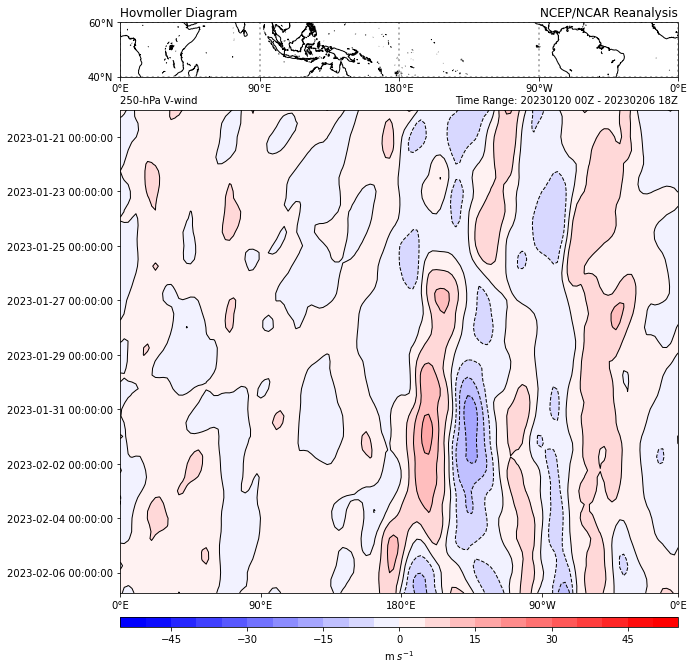

In [4]:
# Start figure
fig = plt.figure(figsize=(10, 13))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)

# Tick labels
x_tick_labels = [u'0\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'180\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}E']

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
#ax1.set_extent([0, 357.5, 35, 65], ccrs.PlateCarree(central_longitude=180))

ax1.set_extent([0, 357.5, -15, 10], ccrs.PlateCarree(central_longitude=180))

#ax1.set_yticks([40, 60])

ax1.set_yticks([-20, 15])

ax1.set_yticklabels([u'40\N{DEGREE SIGN}N', u'60\N{DEGREE SIGN}N'])
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='dotted', linewidth=2)

# Add geopolitical boundaries for map reference
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)

# Set some titles
plt.title('Hovmoller Diagram', loc='left')
plt.title('NCEP/NCAR Reanalysis', loc='right')

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
clevs = np.arange(-50, 51, 5)
cf = ax2.contourf(lons, vtimes, mpcalc.smooth_n_point(
    avg_data, 9, 2), clevs, cmap=plt.cm.bwr, extend='both')
cs = ax2.contour(lons, vtimes, mpcalc.smooth_n_point(
    avg_data, 9, 2), clevs, colors='k', linewidths=1)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_label('m $s^{-1}$')

# Make some ticks and tick labels
ax2.set_xticks([0, 90, 180, 270, 357.5])
ax2.set_xticklabels(x_tick_labels)
ax2.set_yticks(vtimes[4::8])
ax2.set_yticklabels(vtimes[4::8])

# Set some titles
plt.title('250-hPa V-wind', loc='left', fontsize=10)
plt.title('Time Range: {0:%Y%m%d %HZ} - {1:%Y%m%d %HZ}'.format(vtimes[0], vtimes[-1]),
          loc='right', fontsize=10)

plt.show()